## **Project: Concrete Compressive Strength Model**
- **Source**: I, Yeh (1988). Modeling of strength of high-performance concrete using artificial neural networks. Published in Cement and Concrete Research, Vol. 28, No. 12
- **Date**: 10/01/24
- **Goal**: Create a basic prediction model and a feature explainer

In [1]:
# Step 0. Import libraries and custom modules
# Basics ---------------------------------------------------------------
import logging
import pickle
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_predict,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    ElasticNet
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.inspection import permutation_importance
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### **1. Data loading**
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
# Step 1. Load the data
# 1.1 Retrieve data from source and get info
df_raw = pd.read_excel("../../data/concrete_data.xls")
display(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

None

In [3]:
# 1.2 Show a sample
df_raw.sample(10, random_state=2024)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
556,193.50,290.2,0.00,185.70,0.00,998.20,704.3,28,32.626694
928,149.00,153.0,194.00,192.00,8.00,935.00,623.0,28,24.579819
99,469.00,117.2,0.00,137.80,32.20,852.10,840.5,7,54.896079
802,339.00,0.0,0.00,185.00,0.00,1060.00,754.0,28,31.646948
496,387.00,20.0,94.00,157.00,11.61,938.00,845.0,56,61.459891
615,277.00,0.0,0.00,191.00,0.00,968.00,856.0,180,32.329530
299,290.35,0.0,96.18,168.08,9.41,961.18,865.0,3,22.504497
938,154.80,183.4,0.00,193.30,9.10,1047.40,696.7,28,18.287661
672,173.00,116.0,0.00,192.00,0.00,946.80,856.8,3,6.940955
427,190.34,0.0,125.18,166.61,9.88,1079.00,798.9,14,19.415644


##### **Data dictionary**
|Name|Description|Type|Units|
|----|-----------|----|-----|
|cement|Cement (component 1)(kg in a m^3 mixture)|Float|kg/m^3|
|blast_furnace_slag|Blast Furnace Slag (component 2)(kg in a m^3 mixture)|Float|kg/m^3|
|fly_ash|Fly Ash (component 3)(kg in a m^3 mixture)|Float|kg/m^3|
|water|Water (component 4)(kg in a m^3 mixture)|Float|kg/m^3|
|superplasticizer|Superplasticizer (component 5)(kg in a m^3 mixture)|Float|kg/m^3|
|coarse_aggregate|Coarse Aggregate (component 6)(kg in a m^3 mixture)|Float|kg/m^3|
|fine_aggregate|Fine Aggregate (component 7)(kg in a m^3 mixture)|Float|kg/m^3|
|age|Age (day)|Int|day|
|compressive_strength|Concrete compressive strength(MPa, megapascals)|Float|megapascals|


### **2. Data preprocessing**
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [4]:
df_baking = df_raw.copy()
df_baking.columns = (
    ['cement','blast_furnace_slag','fly_ash','water'] + 
    ['superplasticizer','coarse_aggregate','fine_aggregate'] + 
    ['age','compressive_strength']
)
# Step added after EDA and results ongoing -----------------------------
compressive_strenght = df_baking['compressive_strength'].copy()
df_baking['log_age'] = df_baking['age'].apply(lambda x: np.log(x))
df_baking = df_baking.drop(['age','compressive_strength'], axis=1)
df_baking['compressive_strength'] = compressive_strenght
# End of step ----------------------------------------------------------
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cement                1030 non-null   float64
 1   blast_furnace_slag    1030 non-null   float64
 2   fly_ash               1030 non-null   float64
 3   water                 1030 non-null   float64
 4   superplasticizer      1030 non-null   float64
 5   coarse_aggregate      1030 non-null   float64
 6   fine_aggregate        1030 non-null   float64
 7   log_age               1030 non-null   float64
 8   compressive_strength  1030 non-null   float64
dtypes: float64(9)
memory usage: 72.5 KB


### **3. Exploratory Data Analysis**
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [5]:
# Step 3. EDA
# 3.1 Create train and test splits
df_train, df_test = train_test_split(df, test_size=0.2, 
                                     random_state=2024)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [6]:
# 3.2 Display descriptive statistics
display(df_train.describe(include='number').T)

,count,mean,std,min,25%,50%,75%,max
cement,824.0,276.063301,102.351513,102.000000,190.340000,260.950000,342.000000,540.000000
blast_furnace_slag,824.0,73.639794,86.663678,0.000000,0.000000,20.000000,142.500000,359.400000
fly_ash,824.0,55.658313,64.430568,0.000000,0.000000,0.000000,118.270000,200.100000
water,824.0,181.741954,21.080847,121.750000,164.900000,185.000000,192.000000,247.000000
superplasticizer,824.0,6.072825,5.866100,0.000000,0.000000,6.165000,10.100000,32.200000
coarse_aggregate,824.0,972.448119,76.833744,801.000000,932.000000,968.000000,1028.400000,1145.000000
fine_aggregate,824.0,775.057002,79.499894,594.000000,734.300000,780.045000,825.000000,992.600000
log_age,824.0,3.161526,1.183907,0.000000,1.945910,3.332205,4.025352,5.899897
compressive_strength,824.0,35.210472,16.482486,2.331808,23.239281,33.723995,44.739581,82.599225


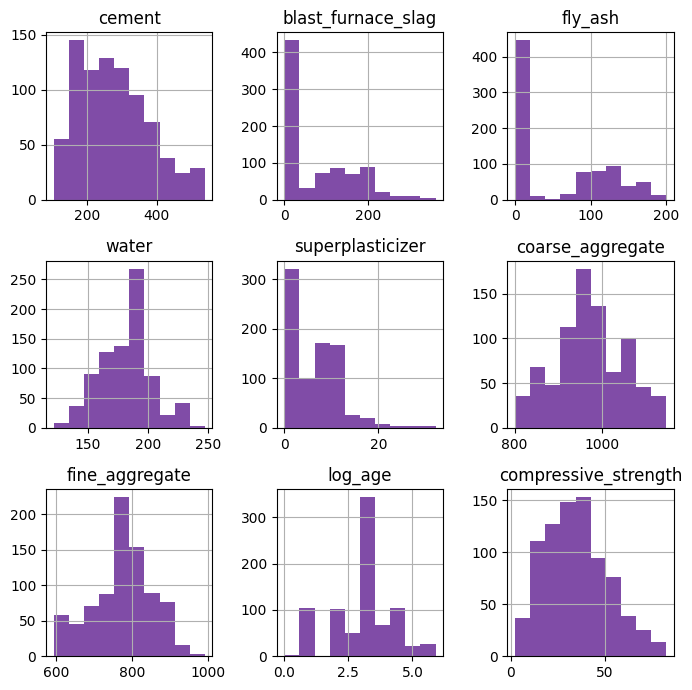

In [7]:
# 3.3 Display univariate analysis - Numeric 
df_train.hist(figsize=(7,7), color='Indigo', alpha=0.7)
plt.tight_layout()
plt.show()

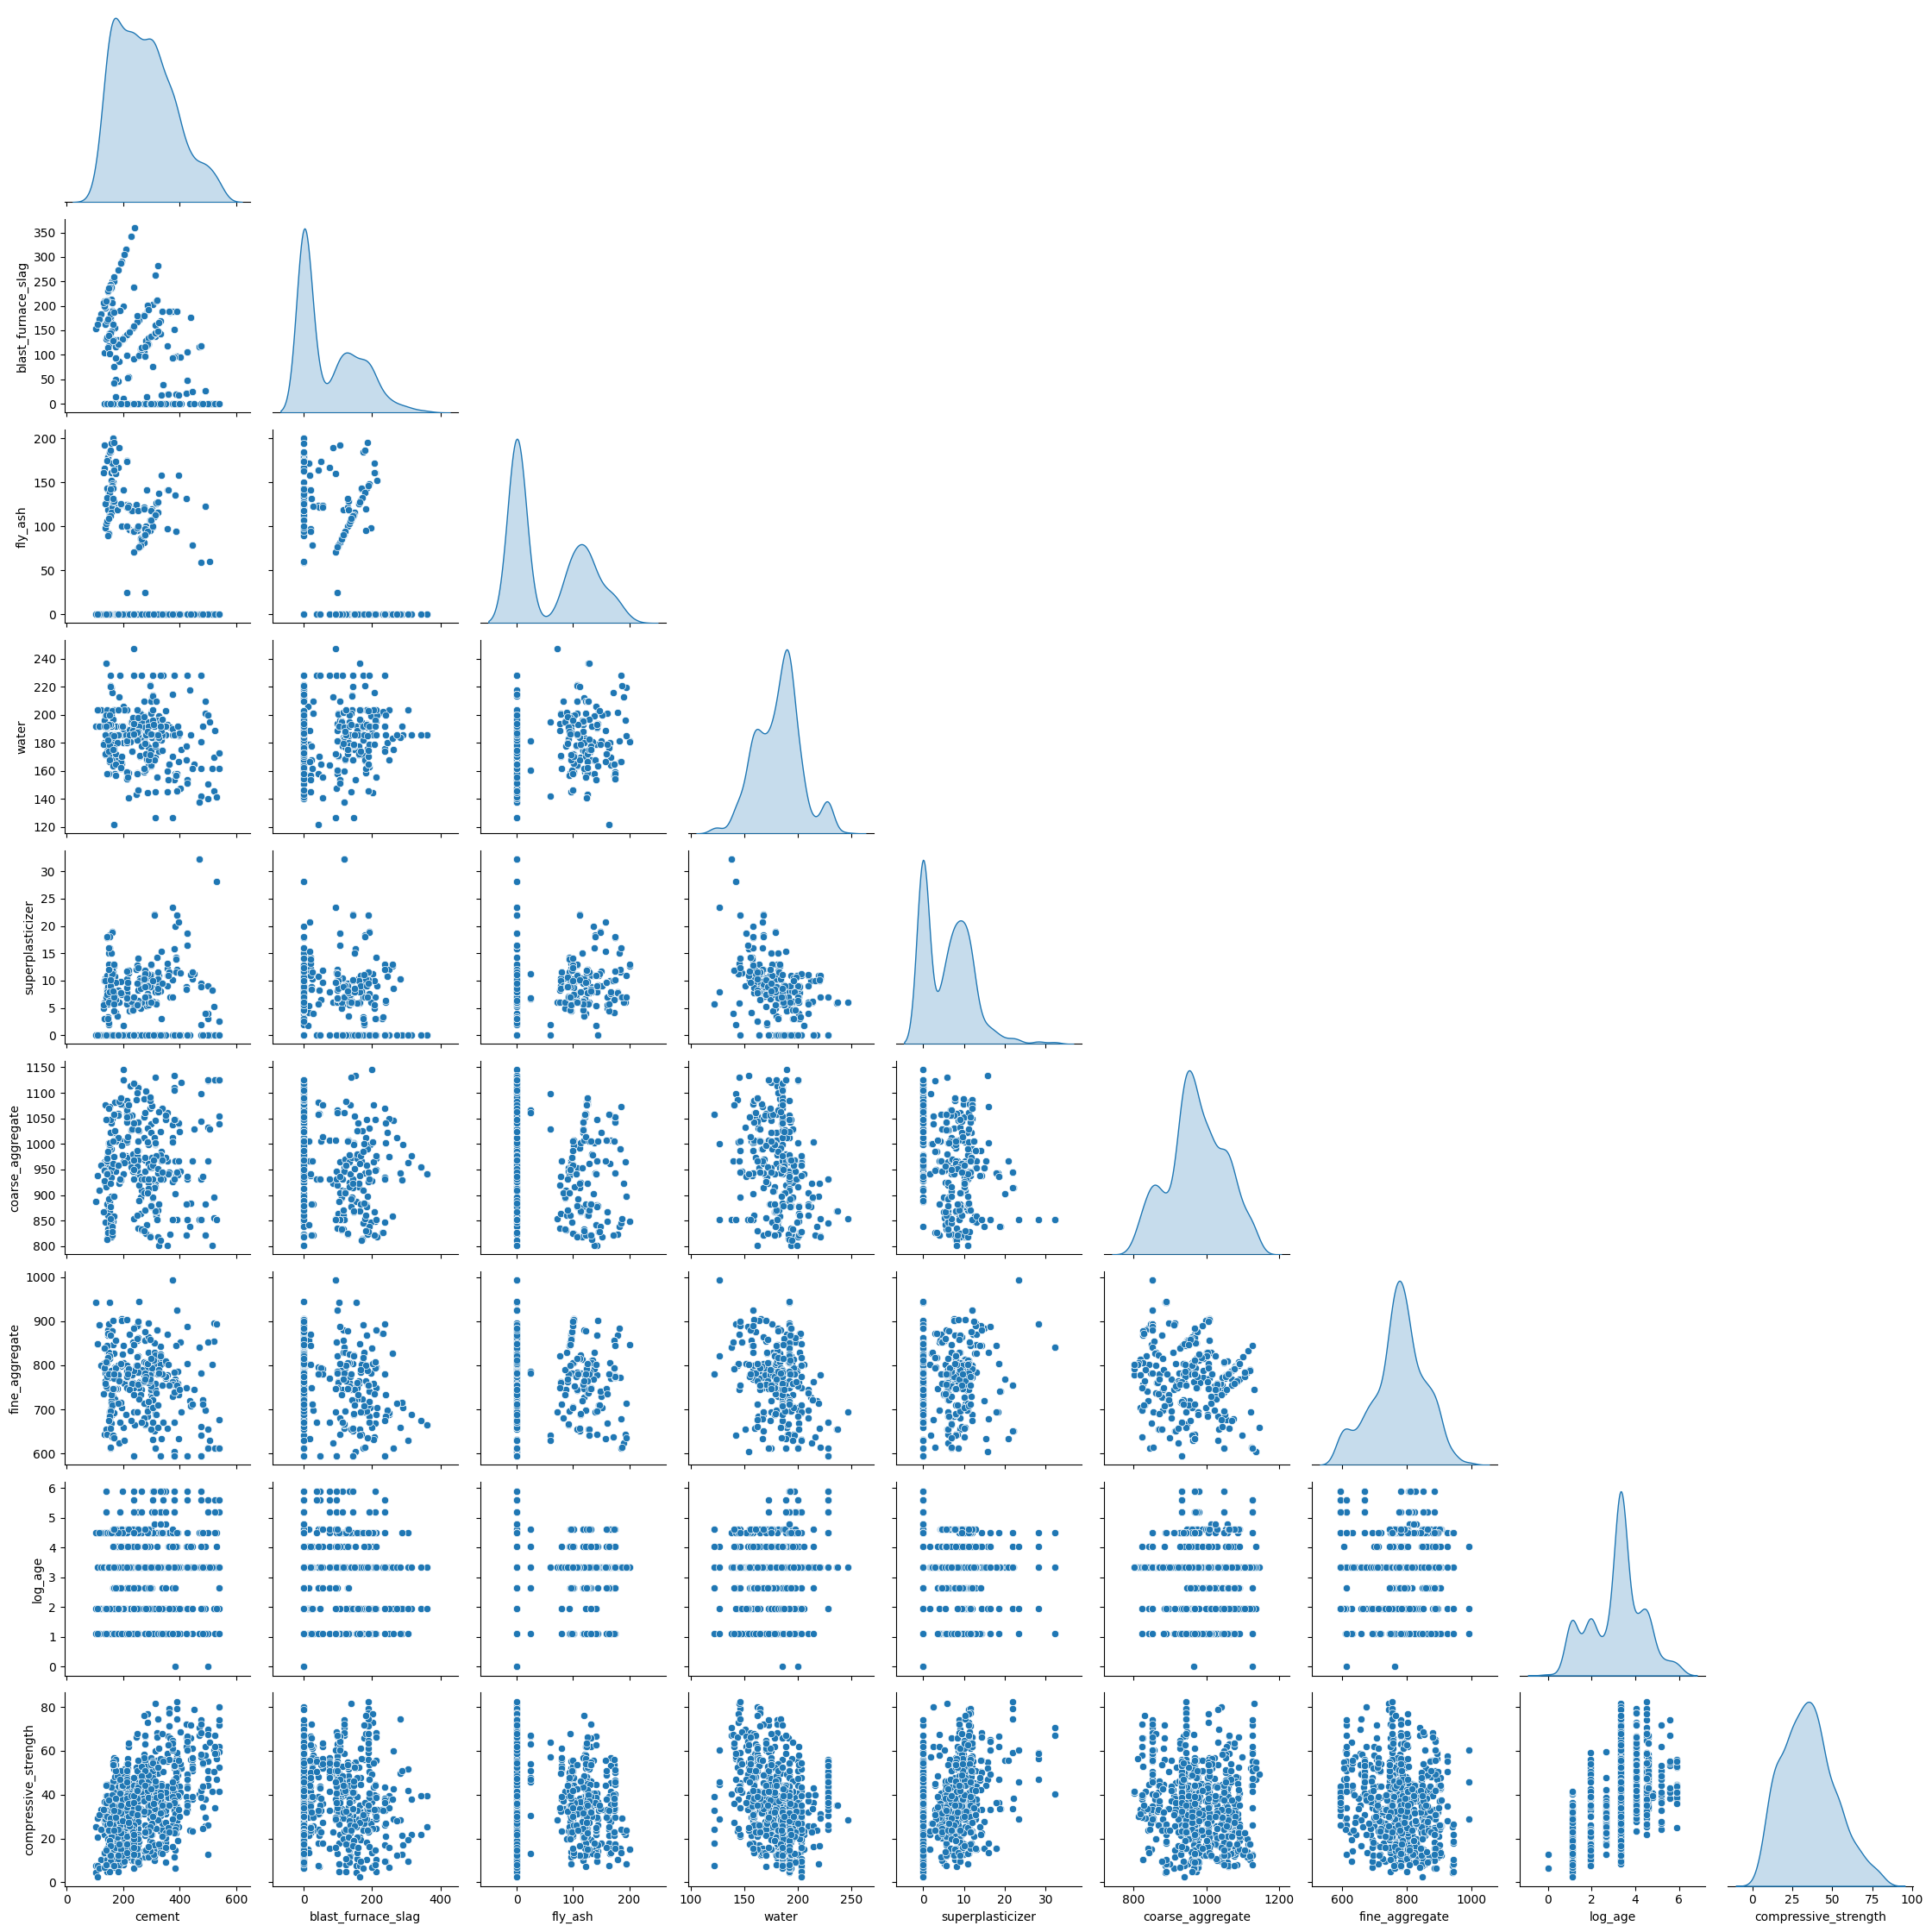

In [8]:
# 3.3 Display bivariate analysis - Numeric 
sns.pairplot(df_train, diag_kind='kde', corner=True)
plt.tight_layout()
plt.show()

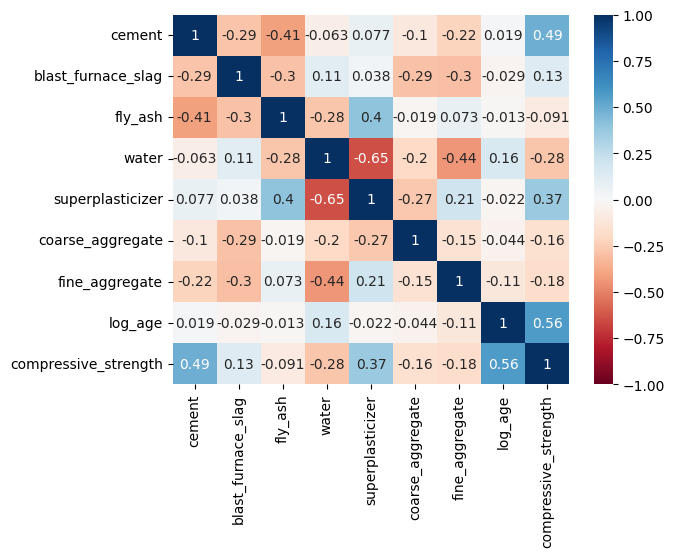

In [9]:
# 2.3 Perform correlation analysis
sns.heatmap(
    data=df_train.select_dtypes('number').corr(), 
    vmin=-1, vmax=1, cmap='RdBu', annot=True
)
plt.show()

In [10]:
# Step 4. Create a machine learning model
# 4.1 Split features and reponse
X_train = df_train.drop('compressive_strength', axis=1).reset_index(drop=True)
y_train = df_train['compressive_strength'].reset_index(drop=True)
X_test = df_test.drop('compressive_strength', axis=1).reset_index(drop=True)
y_test = df_test['compressive_strength'].reset_index(drop=True)

In [11]:
# 4.2 Create a model based on a pipeline and train
lreg_p = Pipeline([
    ('scaler', MinMaxScaler()),
    ('lreg', LinearRegression())
])
lreg_p.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('lreg', LinearRegression())])

In [12]:
# 4.3 Make the predictions and evaluate the results
y_hat = lreg_p.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_hat):.2f}')
print(f'MSE: {mean_squared_error(y_test, y_hat):.2f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat)):.2f}')
print(f'R2: {r2_score(y_test, y_hat):.2f}')

MAE: 5.43
MSE: 48.00
RMSE: 6.93
R2: 0.84


In [13]:
# 4.4 Make a cross validation over 5 folds
scores = cross_validate(
    lreg_p, X_train, y_train, 
    cv=10,
    return_train_score=True, 
    return_estimator=True
)
display(pd.DataFrame(scores))
print(
    f"Mean R2 train: {scores['train_score'].mean():.2f}", 
    f"SD: {scores['train_score'].std():.2}"
)
print(
    f"Mean R2 test: {scores['test_score'].mean():.2f}", 
    f"SD: {scores['test_score'].std():.2}"
)


,fit_time,score_time,estimator,test_score,train_score
0,0.002248,0.000813,"(MinMaxScaler(), LinearRegression())",0.808280,0.810381
1,0.001890,0.000633,"(MinMaxScaler(), LinearRegression())",0.815172,0.809582
2,0.002460,0.000590,"(MinMaxScaler(), LinearRegression())",0.795817,0.811161
3,0.001291,0.000518,"(MinMaxScaler(), LinearRegression())",0.816729,0.809628
4,0.001498,0.000605,"(MinMaxScaler(), LinearRegression())",0.799516,0.811322
5,0.001114,0.000466,"(MinMaxScaler(), LinearRegression())",0.806160,0.810216
6,0.001053,0.000475,"(MinMaxScaler(), LinearRegression())",0.839064,0.806874
7,0.001162,0.000501,"(MinMaxScaler(), LinearRegression())",0.761910,0.813913
8,0.001843,0.000605,"(MinMaxScaler(), LinearRegression())",0.792158,0.812834
9,0.001489,0.000599,"(MinMaxScaler(), LinearRegression())",0.788364,0.813057


Mean R2 train: 0.81 SD: 0.0019
Mean R2 test: 0.80 SD: 0.019


In [14]:
# 4.5 Get the metrics on cross validation
y_hat_cv = cross_val_predict(lreg_p, X_test, y_test, cv=10)
print(f'CV MAE: {mean_absolute_error(y_test, y_hat_cv):.2f}')
print(f'CV MSE: {mean_squared_error(y_test, y_hat_cv):.2f}')
print(f'CV RMSE: {np.sqrt(mean_squared_error(y_test, y_hat_cv)):.2f}')
print(f'CV R2: {r2_score(y_test, y_hat_cv):.2f}')

CV MAE: 5.64
CV MSE: 50.68
CV RMSE: 7.12
CV R2: 0.83


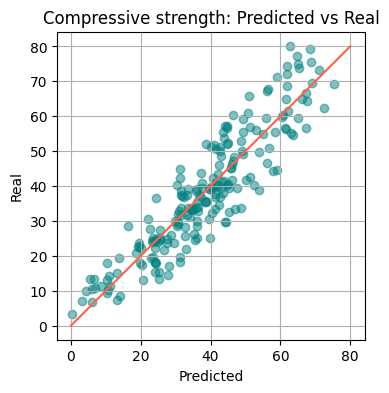

In [15]:
# 4.6 Plot the points agaist the prediction
plt.figure(figsize=(4,4))
plt.scatter(x=y_hat_cv, y=y_test, alpha=0.5, c='Teal')
plt.plot([0, 80], [0, 80], color='Tomato')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Compressive strength: Predicted vs Real')
plt.grid(True)
plt.axis('square')
plt.show()

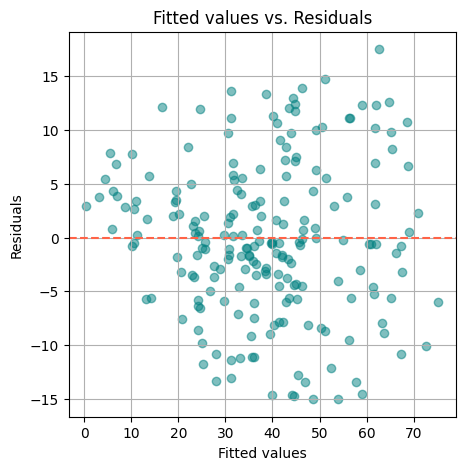

In [16]:
# 4.7 Plot the residuals against the fitted values
resid = y_test - y_hat_cv
plt.figure(figsize=(5, 5))
plt.scatter(x=y_hat_cv, y=resid, c='Teal', alpha=0.5)
plt.axhline(0, linestyle='--', c='Tomato')
plt.title('Fitted values vs. Residuals')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

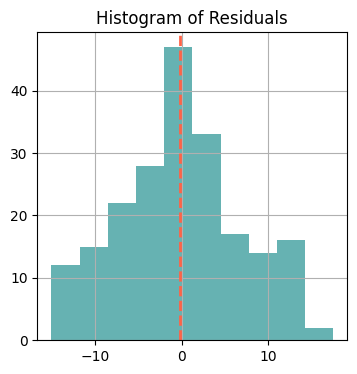

In [17]:
# 4.9 Plot the histogram of residuals
plt.figure(figsize=(4,4))
plt.hist(resid, color='Teal', alpha=0.6)
plt.axvline(resid.mean(), color='Tomato', linestyle='--', linewidth=2)
plt.grid(True)
plt.title('Histogram of Residuals')
plt.show()

In [18]:
# 4.9 View the coeficients
print(f"Intercept: {lreg_p['lreg'].intercept_:.2f}") # Beta_0
print(f"Coefficients: {lreg_p['lreg'].coef_.round(3)}") # Beta_i
intercept_df = pd.DataFrame(
    lreg_p['lreg'].intercept_.round(3),
    index=['intercept'],
    columns=['Coefficient']
)
coefficients_df = pd.DataFrame(
    lreg_p['lreg'].coef_.round(3), 
    X_train.columns, 
    columns=['Coefficient']
)
pd.concat([intercept_df, coefficients_df])

Intercept: -33.57
Coefficients: [ 58.068  40.334  17.973 -14.902   5.915  10.421  13.135  50.956]


,Coefficient
intercept,-33.573
cement,58.068
blast_furnace_slag,40.334
fly_ash,17.973
water,-14.902
superplasticizer,5.915
coarse_aggregate,10.421
fine_aggregate,13.135
log_age,50.956


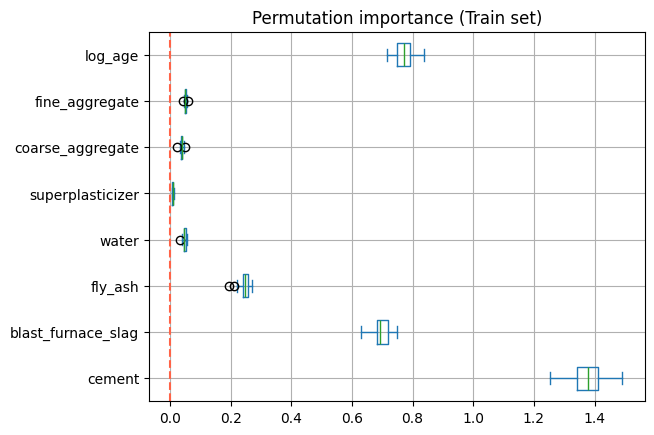

In [19]:
# 4.9 View the importance of the variables
importance = permutation_importance(
    lreg_p, X_train, y_train, 
    n_repeats=25, random_state=2024
)
importance_df = pd.DataFrame(
    importance.importances.T, 
    columns=X_train.columns
)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0, color='k', linestyle='--', c='Tomato')
ax.set_title('Permutation importance (Train set)')
ax.grid(True)
plt.show()

In [20]:
# 4.10 Analyze Lasso regression regularization
scores_dict = {
    'alpha': 10.0 ** np.arange(-3,4,1),
    'mean_train_scores': [],
    'mean_test_scores': []
}

for alpha in scores_dict['alpha']:
    lasso_p = Pipeline([
        ('scaler', MinMaxScaler()),
        ('lasso', Lasso(alpha=alpha))
    ])
    scores = cross_validate(
        lasso_p, X_train, y_train, 
        return_train_score=True
    )
    scores_dict['mean_train_scores'].append(scores['train_score'].mean())
    scores_dict['mean_test_scores'].append(scores['test_score'].mean())

results_lasso_df = pd.DataFrame(scores_dict)
results_lasso_df # Smaller alpha, likely overfit, large alpha, underfit

,alpha,mean_train_scores,mean_test_scores
0,0.001,0.811334,0.804834
1,0.010,0.810711,0.804376
2,0.100,0.800083,0.795685
3,1.000,0.414537,0.409438
4,10.000,0.000000,-0.003239
5,100.000,0.000000,-0.003239
6,1000.000,0.000000,-0.003239


In [21]:
# 4.11 Create the ridge model based on a pipeline and get metrics
lasso_p = Pipeline([
        ('scaler', MinMaxScaler()),
        ('lasso', Lasso(alpha=0.1))
])
lasso_p.fit(X_train, y_train)
y_hat_r = lasso_p.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_hat_r):.2f}')
print(f'MSE: {mean_squared_error(y_test, y_hat_r):.2f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat_r)):.2f}')
print(f'R2: {r2_score(y_test, y_hat_r):.2f}')
print(f"Intercept: {lasso_p['lasso'].intercept_:.2f}") # Beta_0
print(f"Coefficients: {lasso_p['lasso'].coef_.round(3)}") # Beta_i

MAE: 5.71
MSE: 54.04
RMSE: 7.35
R2: 0.82
Intercept: -3.59
Coefficients: [ 41.799  24.575   7.577 -24.192   6.667   0.     -0.     47.356]


In [22]:
# 4.10 Analyze Ridge regression regularization
scores_dict = {
    'alpha': 10.0 ** np.arange(-3,4,1),
    'mean_train_scores': [],
    'mean_test_scores': []
}

for alpha in scores_dict['alpha']:
    ridge_p = Pipeline([
        ('scaler', MinMaxScaler()),
        ('ridge', Ridge(alpha=alpha))
    ])
    scores = cross_validate(
        ridge_p, X_train, y_train, 
        return_train_score=True
    )
    scores_dict['mean_train_scores'].append(scores['train_score'].mean())
    scores_dict['mean_test_scores'].append(scores['test_score'].mean())

results_ridge_df = pd.DataFrame(scores_dict)
results_ridge_df # Smaller alpha, likely overfit, large alpha, underfit

,alpha,mean_train_scores,mean_test_scores
0,0.001,0.811340,0.804821
1,0.010,0.811338,0.804835
2,0.100,0.811203,0.804838
3,1.000,0.806135,0.800367
4,10.000,0.735314,0.730141
5,100.000,0.326843,0.321469
6,1000.000,0.048228,0.044524


In [23]:
# 4.12 Create the ridge model based on a pipeline and get metrics
ridge_p = Pipeline([
        ('scaler', MinMaxScaler()),
        ('ridge', Ridge(alpha=0.1))
])
ridge_p.fit(X_train, y_train)
y_hat_r = ridge_p.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_hat_r):.2f}')
print(f'MSE: {mean_squared_error(y_test, y_hat_r):.2f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat_r)):.2f}')
print(f'R2: {r2_score(y_test, y_hat_r):.2f}')
print(f"Intercept: {ridge_p['ridge'].intercept_:.2f}") # Beta_0
print(f"Coefficients: {ridge_p['ridge'].coef_.round(3)}") # Beta_i

MAE: 5.44
MSE: 48.25
RMSE: 6.95
R2: 0.84
Intercept: -29.89
Coefficients: [ 56.277  38.649  16.86  -16.476   6.011   9.175  11.315  50.71 ]


In [24]:
# 4.13 Finally, let's finde the best alpha for elasticnet using grid search
elasticnet_p = Pipeline([
    ('scaler', MinMaxScaler()),
    ('elasticnet', ElasticNet())
])
grid = {
    'elasticnet__alpha': 10.0 ** np.arange(-3,4,1)
}
elasticnet_cv = GridSearchCV(
    estimator=elasticnet_p, 
    param_grid=grid, cv=5,
    return_train_score=True
)
elasticnet_cv.fit(X_train, y_train)
pd.DataFrame(elasticnet_cv.cv_results_).iloc[:,[4,-2,-1]]

,param_elasticnet__alpha,mean_train_score,std_train_score
0,0.001,0.810211,0.002694
1,0.010,0.788991,0.002838
2,0.100,0.553152,0.018784
3,1.000,0.084301,0.009673
4,10.000,0.000000,0.000000
5,100.000,0.000000,0.000000
6,1000.000,0.000000,0.000000


### **5. Model saving**
**Objective**: Save the model and some critical information we consider necessary

In [25]:
# Step 5. Save the model for further usage
# 5.1 Create model dictionary
model_dict = {
    'model': lasso_p,
    'predictors': X_train.columns.to_list(),
    'target_name': y_train.name,
    'algorithm_name': 'Lasso Regression'
}

In [26]:
# 5.2 Save the model dictionary
try:
    with open(
        '../../models/concrete_compressive_strength_model.pkl','wb'
    ) as file:
        pickle.dump(model_dict, file)
    logger.info("Save succesful")
except Exception as e:
    logger.error(f"An error occurred: {e}")